In [2]:
import torch
from matplotlib import image
import numpy
from targets import *
from utils import *

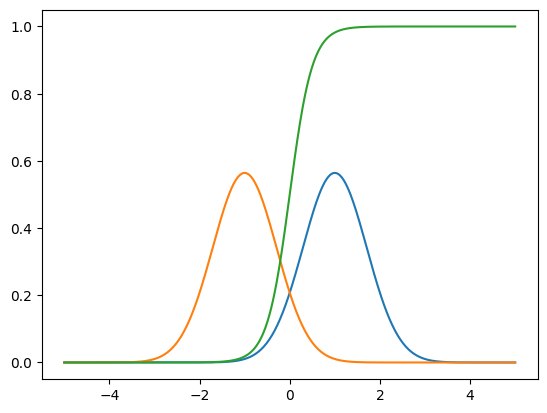

In [11]:
label_1 = torch.distributions.MultivariateNormal(1*torch.ones(1), .5*torch.eye(1))
label_0 = torch.distributions.MultivariateNormal((-1)*torch.ones(1), .5*torch.eye(1))
tt = torch.linspace(-5,5,500)
plt.plot(tt,torch.exp(label_1.log_prob(tt.unsqueeze(-1))).squeeze(-1))
plt.plot(tt,torch.exp(label_0.log_prob(tt.unsqueeze(-1))).squeeze(-1))
plt.plot(tt,(torch.exp(label_1.log_prob(tt.unsqueeze(-1)))/(torch.exp(label_1.log_prob(tt.unsqueeze(-1))) + torch.exp(label_0.log_prob(tt.unsqueeze(-1))))).squeeze(-1))

In [12]:
from classifiers import BinaryClassifier
label_0_samples= label_0.sample([1000])
label_1_samples= label_1.sample([1000])
binary_classif = BinaryClassifier(label_0_samples, label_1_samples,[128,128,128])
binary_classif.train(100, 2000)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:10<00:00,  9.59it/s, loss = 0.361831; device = cpu]


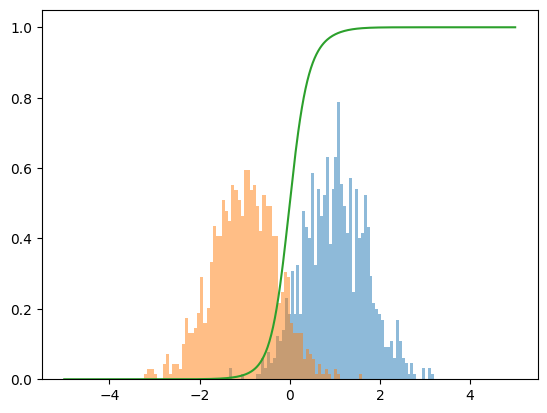

In [13]:
plt.hist(label_1_samples.numpy(), density =True, bins = 70, alpha = .5)
plt.hist(label_0_samples.numpy(), density =True, bins = 70, alpha =.5)
plt.plot(tt, torch.sigmoid(binary_classif.logit_r(tt.unsqueeze(-1))).squeeze(-1).detach().numpy())
plt.show()

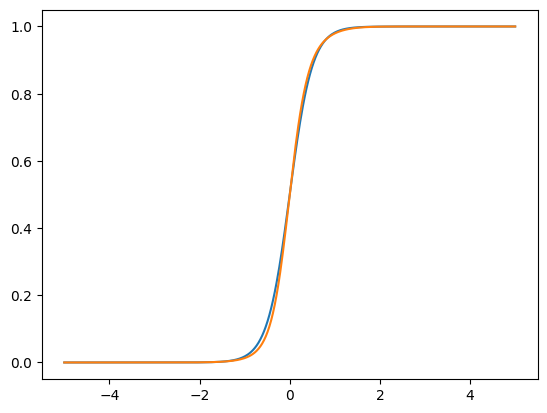

In [14]:
plt.plot(tt,(torch.exp(label_1.log_prob(tt.unsqueeze(-1)))/(torch.exp(label_1.log_prob(tt.unsqueeze(-1))) + torch.exp(label_0.log_prob(tt.unsqueeze(-1))))).squeeze(-1))
plt.plot(tt, torch.sigmoid(binary_classif.logit_r(tt.unsqueeze(-1))).squeeze(-1).detach().numpy())
plt.show()

In [10]:
target = TwoCircles()
target_samples = target.sample([3000])
cov = torch.cov(target_samples.T)
mean = torch.mean(target_samples, dim = 0)
instrumental = torch.distributions.MultivariateNormal(mean, cov)
proposed_samples = instrumental.sample([3000])

In [11]:
binary_classif = BinaryClassifier(proposed_samples, target_samples,[128,128,128])
binary_classif.train(100, 1000)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:19<00:00,  5.08it/s, loss = 226.105957; device = cpu]


In [16]:
prob = lambda x: torch.exp(binary_classif.logit_r(x).squeeze(-1) + instrumental.log_prob(x))

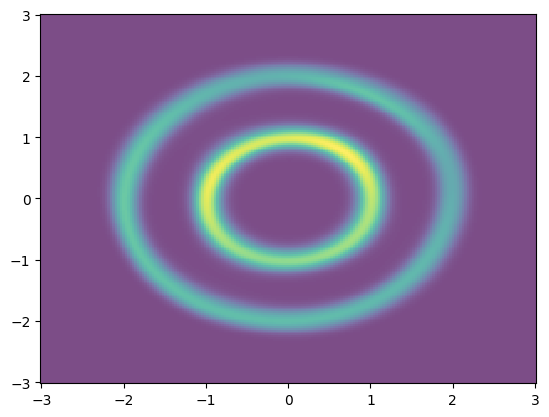

In [17]:
from utils import *
plot_2d_function(prob, bins = [200,200], range = [[-3, 3],[-3,3]])